In [1]:
import os as os


import pandas as pd
from bigdatavqa.coreset import Coreset
from bigdatavqa.k3meansclustering import K3MeansClusteringVQE, K3MeansClusteringRandom, K3MeansClusteringMaxCut, K3MeansClusteringKMeans
from bigdatavqa.vqe_utils import get_VQE_circuit, get_K3_Hamiltonian
from bigdatavqa.optimizer import get_optimizer_for_VQE
import cudaq
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
qubits = 10
number_of_qubits_representing_data_point = 2
coreset_size = int(qubits / number_of_qubits_representing_data_point)
circuit_depth = 1
max_shots = 1000
max_iterations = 100
number_of_experiment_runs = 5
number_of_corsets_to_evaluate = 15
number_of_centroid_evaluation = 20

Using BFL2 method to generate coresets


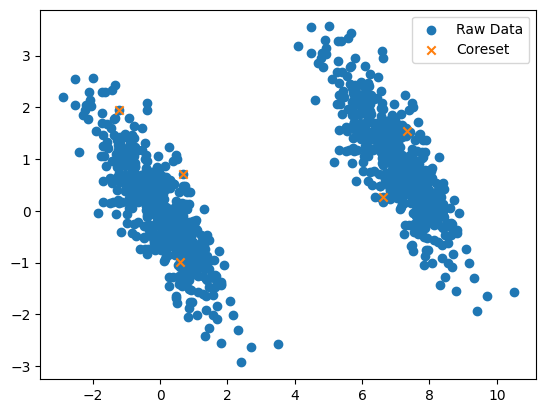

In [3]:
raw_data = Coreset.create_dataset(1000)
raw_data_df = pd.DataFrame(raw_data, columns=list("XY"))

coreset = Coreset(
    raw_data=raw_data,
    number_of_sampling_for_centroids=10,
    coreset_size=coreset_size,
    number_of_coresets_to_evaluate=4,
    coreset_method="BFL2",
)

coreset_vectors, coreset_weights = coreset.get_best_coresets()

coreset_df = pd.DataFrame(coreset_vectors, columns=list("XY"))
coreset_df["weights"] = coreset_weights
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]

plt.scatter(raw_data_df["X"], raw_data_df["Y"], label="Raw Data")
plt.scatter(coreset_df["X"], coreset_df["Y"], label="Coreset", marker="x")
plt.legend()
plt.show()


In [4]:
optimizer = cudaq.optimizers.COBYLA()

k3meansVQE = K3MeansClusteringVQE(
        qubits=qubits,
        create_circuit=get_VQE_circuit,
        circuit_depth=1,
        optimizer_function=get_optimizer_for_VQE,
        optimizer=optimizer,
        create_Hamiltonian=get_K3_Hamiltonian,
        number_of_qubits_representing_data=number_of_qubits_representing_data_point,
        normalize_vectors=True,
        max_iterations=max_iterations,
        max_shots=max_shots,
    )

centers = k3meansVQE.get_cluster_centers(
    coreset_df=coreset_df, vector_columns=["X", "Y"], weight_columns="weights"
)


VQE_cost_value, labels = k3meansVQE.get_3means_cost(
    coreset_vectors, centers
)


print(f"VQE cost value: {VQE_cost_value}")

VQE cost value: 9.263871971367141


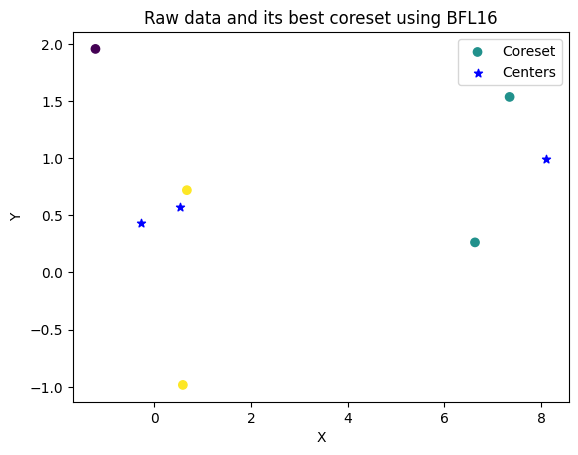

In [5]:
coreset_df["k"] = labels

plt.scatter(coreset_df["X"], coreset_df["Y"], c=coreset_df["k"], label="Coreset", cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], label="Centers", color="b", marker="*")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raw data and its best coreset using BFL16")
plt.legend()
plt.show()

## KMeans clustering

In [6]:
K3meansKMeans =  K3MeansClusteringKMeans(normalize_vectors=False)

centers = K3meansKMeans.get_cluster_centers(
    coreset_df=raw_data_df, vector_columns=["X", "Y"], weight_columns="weights"
)

KMeans_cost, labels = K3meansKMeans.get_3means_cost(
    coreset_vectors, centers
)

print(f"KMeans cost value: {KMeans_cost}")


KMeans cost value: 4.856941025775153


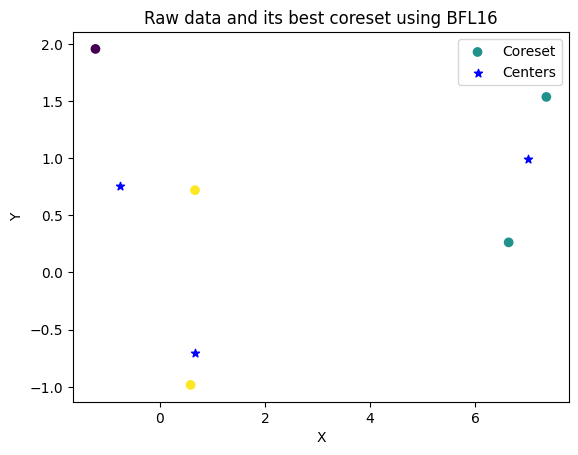

In [7]:
coreset_df["k"] = labels

plt.scatter(coreset_df["X"], coreset_df["Y"], c=coreset_df["k"], label="Coreset", cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], label="Centers", color="b", marker="*")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raw data and its best coreset using BFL16")
plt.legend()
plt.show()

## Random clustering

In [8]:
K3MeansRandom = K3MeansClusteringRandom(number_of_qubits_representing_data=number_of_qubits_representing_data_point)
centers = K3MeansRandom.get_cluster_centers(
    coreset_df=coreset_df, vector_columns=["X", "Y"], weight_columns="weights"
)

random_cost,labels = K3MeansRandom.get_3means_cost(coreset_vectors, centers)


print(f"Random cost value: {random_cost}")

Random cost value: 19.935501684252728


In [9]:
labels

[1, 0, 0, 0, 1]

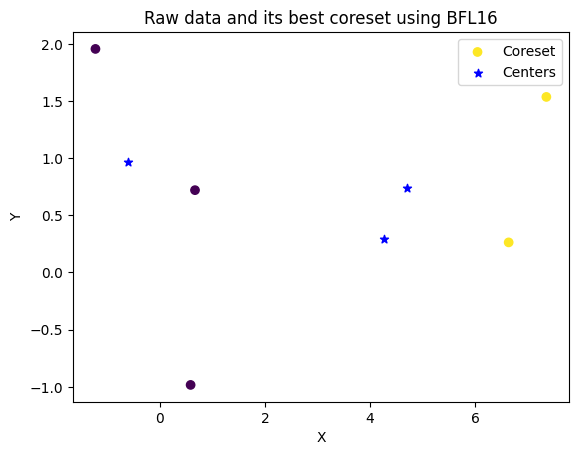

In [10]:
coreset_df["k"] = labels

plt.scatter(coreset_df["X"], coreset_df["Y"], c=coreset_df["k"], label="Coreset", cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], label="Centers", color="b", marker="*")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raw data and its best coreset using BFL16")
plt.legend()
plt.show()

## MaxCut

In [11]:
K3MeansMaxCut = K3MeansClusteringMaxCut()
centers = K3MeansMaxCut.get_cluster_centers(
    coreset_df=coreset_df, vector_columns=["X", "Y"], weight_columns="weights"
)

MaxCut_cost, labels = K3MeansMaxCut.get_3means_cost(coreset_vectors, centers)

print(f"MaxCut cost value: {MaxCut_cost}")

100%|██████████| 1022/1022 [00:02<00:00, 408.87it/s]

MaxCut cost value: 2.5218300750455636


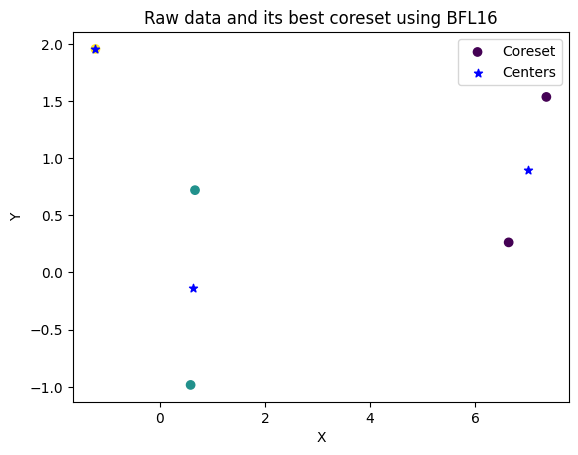

In [12]:
coreset_df["k"] = labels

plt.scatter(coreset_df["X"], coreset_df["Y"], c=coreset_df["k"], label="Coreset", cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], label="Centers", color="b", marker="*")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raw data and its best coreset using BFL16")
plt.legend()
plt.show()

# Analyzing results

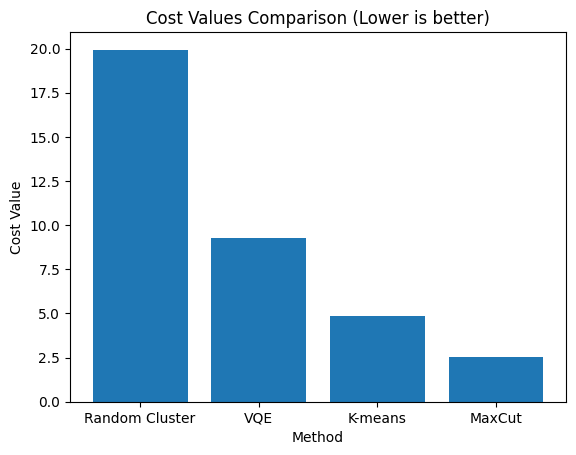

In [13]:
cost_values = [random_cost, 
               VQE_cost_value, 
               KMeans_cost, 
               MaxCut_cost]


labels = ['Random Cluster',
          'VQE', 
          'K-means', 
          'MaxCut']


plt.bar(labels, cost_values)


plt.xlabel('Method')
plt.ylabel('Cost Value')
plt.title('Cost Values Comparison (Lower is better)')


plt.show()